In [144]:
import polars as pl 
import polars_ds as pds
import polars_xdt as xdt
import polars.selectors as cs
import holidays
import os 
from sklearn.model_selection import train_test_split
from sklearn import metrics 
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Read the data 

In [145]:
data = pl.read_csv('train.csv')

Clean the column names 

In [146]:
data = (data
.select(pl.all().name.map(lambda x:x.lower()))
.select(pl.all().name.map(lambda x:x.replace("-"," ")))
.select(pl.all().name.map(lambda x:x.replace(" ","_")))
)

data.head()

row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,state,postal_code,region,product_id,category,sub_category,product_name,sales
i64,str,str,str,str,str,str,str,str,str,str,i64,str,str,str,str,str,f64
1,"""CA-2017-152156""","""08/11/2017""","""11/11/2017""","""Second Class""","""CG-12520""","""Claire Gute""","""Consumer""","""United States""","""Henderson""","""Kentucky""",42420,"""South""","""FUR-BO-10001798""","""Furniture""","""Bookcases""","""Bush Somerset Collection Bookc…",261.96
2,"""CA-2017-152156""","""08/11/2017""","""11/11/2017""","""Second Class""","""CG-12520""","""Claire Gute""","""Consumer""","""United States""","""Henderson""","""Kentucky""",42420,"""South""","""FUR-CH-10000454""","""Furniture""","""Chairs""","""Hon Deluxe Fabric Upholstered …",731.94
3,"""CA-2017-138688""","""12/06/2017""","""16/06/2017""","""Second Class""","""DV-13045""","""Darrin Van Huff""","""Corporate""","""United States""","""Los Angeles""","""California""",90036,"""West""","""OFF-LA-10000240""","""Office Supplies""","""Labels""","""Self-Adhesive Address Labels f…",14.62
4,"""US-2016-108966""","""11/10/2016""","""18/10/2016""","""Standard Class""","""SO-20335""","""Sean O'Donnell""","""Consumer""","""United States""","""Fort Lauderdale""","""Florida""",33311,"""South""","""FUR-TA-10000577""","""Furniture""","""Tables""","""Bretford CR4500 Series Slim Re…",957.5775
5,"""US-2016-108966""","""11/10/2016""","""18/10/2016""","""Standard Class""","""SO-20335""","""Sean O'Donnell""","""Consumer""","""United States""","""Fort Lauderdale""","""Florida""",33311,"""South""","""OFF-ST-10000760""","""Office Supplies""","""Storage""","""Eldon Fold 'N Roll Cart System""",22.368


## Null values

Replacing empty values with null values. Only postal_code contains null values (11 nulls)

In [147]:
# It is not possible to check if numeric columns contains empty data ("" or " ")
(data
 .select(pl.all().exclude(pl.String),
         pl.when(
    (cs.string()==" ")|(cs.string()==""))
            .then(pl.lit(None))
            .otherwise(cs.string())
            .name.keep())
.null_count()
)



row_id,postal_code,sales,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,state,region,product_id,category,sub_category,product_name
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Preprocessing

* Changing the format on date columns. Extracting year, month and day from the function.

* Add season (Winter, spring...). This is for analyzing seasonal effects on sales

* Add holidays. Same as above.

In [148]:
# Function for changing the date format
def change_format(data,c):
 data = (data
 .with_columns(pl.col(c).str.split("/"))
 .with_columns(pl.col(c).list.get(0).cast(pl.Int64).alias(c+"_"+'day'),
              pl.col(c).list.get(1).cast(pl.Int64).alias(c+"_"'month'),
              pl.col(c).list.get(2).cast(pl.Int64).alias(c+"_"'year'))
 .with_columns(pl.concat_str([c+"_"'year',c+"_"'month',c+"_"'day'],separator="-").alias(c))
 .with_columns(pl.col(c).cast(pl.Date))
                                 )
 return data

# Add season
def season(data,c):
   data = (data
           .with_columns(season = pl.when((pl.col(c)>=3) & (pl.col(c)<=5))
                         .then(pl.lit('Spring'))
                         .when((pl.col(c)>=6) & (pl.col(c)<=8))
                         .then(pl.lit('Summer'))
                         .when((pl.col(c)>=9) & (pl.col(c)<=11))
                         .then(pl.lit('Autumn'))
                         .otherwise(pl.lit('Winter'))
           )
   )
   return data

# Add holiday 
def holiday_f(data,c):
  
 # Unique years from the data
 unique_years = data.select('order_date_year').sort(by = 'order_date_year').unique()['order_date_year'].to_list()
 
 # Initialize lists
 h = []
 n = []
 
 # Get date and holiday name
 for date, name in holidays.US(years = unique_years).items():
     h.append(str(date))
     n.append(str(name))
 
 # Create a dataframe
 h_data = pl.DataFrame({'holiday':h,'holiday_name':n})
 h_data = h_data.with_columns(pl.col('holiday').cast(pl.Date))
 
 # Join the columns
 data = data.join(other = h_data,left_on='order_date',right_on='holiday',how='left')
 return data

In [149]:
# Changing format
data = (data
.pipe(function=change_format,c = 'order_date')
.pipe(function=change_format,c = 'ship_date')
.pipe(function = season,c = 'order_date_month')
.pipe(function = holiday_f,c = 'order_date_month')
)


## Descriptive statistics

### Aggregate on year

In [8]:
agg_year = (data
.group_by(pl.col('order_date_year').cast(pl.Int64))
.agg(n_observations = pl.len(),
     n_unique_customers = pl.col('customer_id').n_unique(),
     n_unique_products = pl.col('product_id').n_unique(),
     sum_sales = pl.col('sales').sum())
.sort(by = 'order_date_year')
)

agg_year

order_date_year,n_observations,n_unique_customers,n_unique_products,sum_sales
i64,u32,u32,u32,f64
2015,1953,589,1215,479856.2081
2016,2055,567,1226,459436.0054
2017,2534,635,1356,600192.55
2018,3258,690,1518,722052.0192


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='order_date_year', ylabel='sum_sales'>

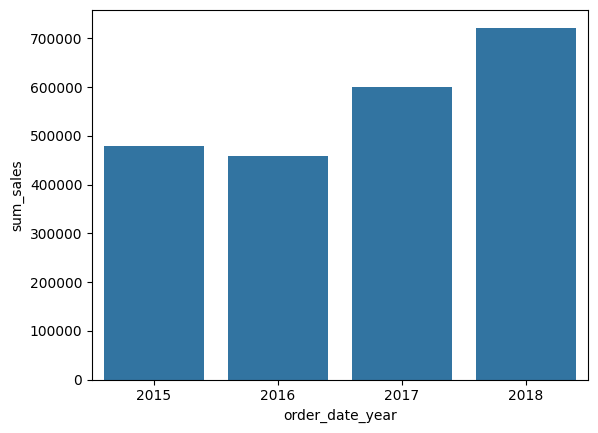

In [9]:
sns.barplot(data = agg_year.to_pandas(),x = 'order_date_year',y = 'sum_sales')

### Season

Clearly, one can see that the sales have it's peak in autumn

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='order_date_year', ylabel='sum_sales'>

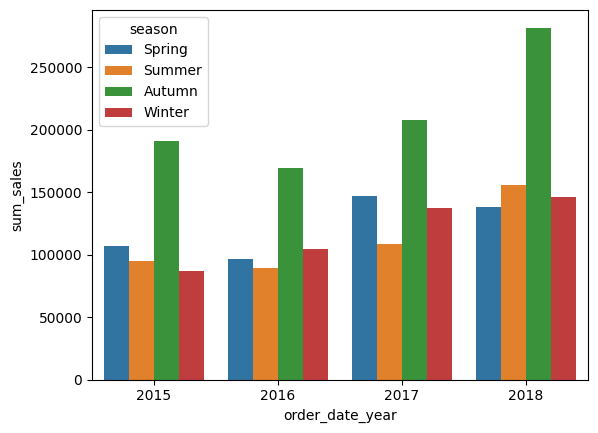

In [159]:

# Adding a "season_id" to sort the seasons in the plot.
agg_year_season = (data
.group_by(pl.col('order_date_year').cast(pl.Int64),'season')
.agg(n_observations = pl.len(),
     n_unique_customers = pl.col('customer_id').n_unique(),
     n_unique_products = pl.col('product_id').n_unique(),
     sum_sales = pl.col('sales').sum())
.with_columns(season_id = pl.when(pl.col('season')=='Spring')
              .then(pl.lit(1))
              .when(pl.col('season')=='Summer')
              .then(pl.lit(2))
              .when(pl.col('season')=='Autumn')
              .then(pl.lit(3))
              .otherwise(pl.lit(4))
)
.sort(by = ['season_id','order_date_year'],descending = [False,False])
.with_columns(pl.col('order_date_year').cast(pl.String))
)

sns.barplot(data=agg_year_season.to_pandas(),x = 'order_date_year',y = 'sum_sales',hue = 'season')

### Monthly sales

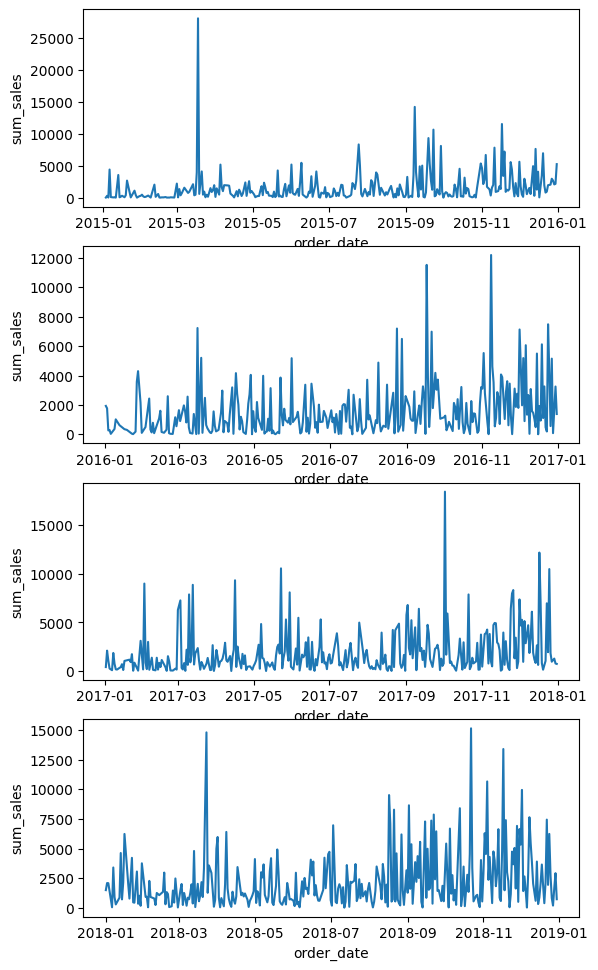

In [184]:
agg_month = (data
.group_by(pl.col('order_date'))
.agg(n_observations = pl.len(),
     n_unique_customers = pl.col('customer_id').n_unique(),
     n_unique_products = pl.col('product_id').n_unique(),
     sum_sales = pl.col('sales').sum())
.with_columns(order_date_year = pl.col('order_date').dt.year().cast(pl.Int64))
.sort(by = 'order_date',descending = False)
)

agg_month_partition = agg_month.partition_by(by = 'order_date_year')

# Creating subplot axes
fig, ax = plt.subplots(4,1)

for (index,year) in enumerate(agg_month_partition):
 ax[index] = sns.lineplot(data = year.to_pandas(),x = 'order_date',y = 'sum_sales',ax = ax[index])

# Adjust the spacing
plt.subplots_adjust(top=2)

In [160]:
# Checking if there are any missing dates
(agg_month
.with_columns(diff = pl.col('order_date')-pl.col('order_date').shift(1).cast(pl.Int64))
.filter(pl.col('order_date').dt.year()==2018,pl.col('order_date').dt.month()==9)
)

order_date,n_observations,n_unique_customers,n_unique_products,sum_sales,diff
date,u32,u32,u32,f64,i64
2018-09-01,7,5,7,1261.81,1
2018-09-02,33,13,33,8652.334,1
2018-09-03,13,8,13,1595.849,1
2018-09-04,28,16,28,5360.202,1
2018-09-05,5,3,5,327.044,1
…,…,…,…,…,…
2018-09-25,13,7,13,1412.213,1
2018-09-26,7,3,7,1486.576,1
2018-09-28,10,5,10,559.271,2


### Category and subcategory

In [12]:
category_and_sub = (data
.group_by('order_date_year','category','sub_category')
.agg(pl.col('sales').sum())
.with_columns(pl.col('sales').sum().over('category','order_date_year').alias('total_category_sum'),
              pl.col('sub_category').n_unique().over('category','order_date_year').alias('n_unique_products'))
.sort(by = ['category','order_date_year','sales'])
)

# Partition the data, such that it can be looped over when creating figs.
category_and_sub_part = category_and_sub.partition_by(by=['category'])

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

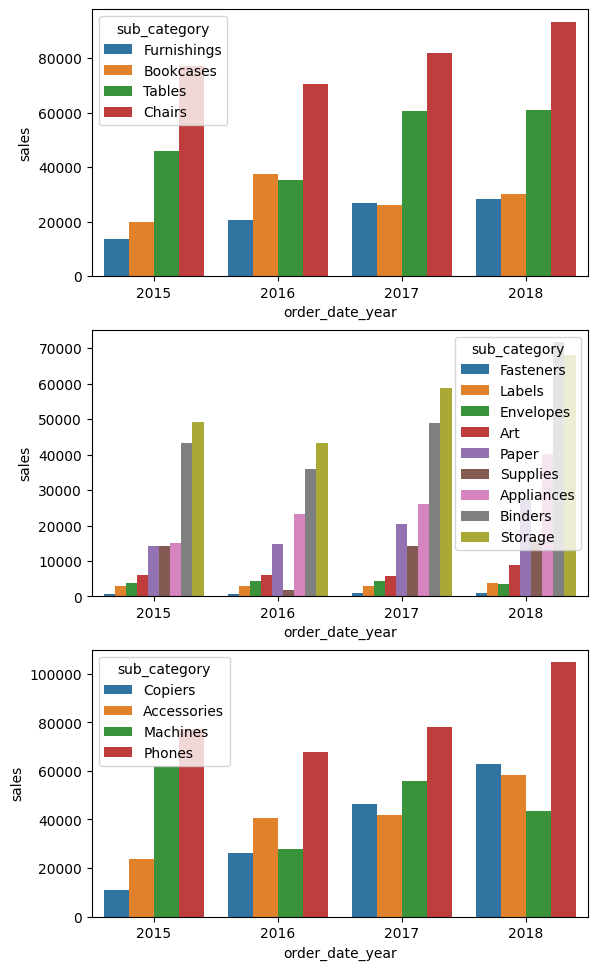

In [59]:
# Creating subplot axes
fig, ax = plt.subplots(3,1)

for (index,category) in enumerate(category_and_sub_part):
  ax[index] = sns.barplot(data = category.to_pandas(),x = 'order_date_year',y = 'sales',hue = 'sub_category',ax = ax[index])

# Adjust the spacing
plt.subplots_adjust(top=2)
